In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import umap
import matplotlib.pylab as plt
import plotly.express as px
import colorcet as cc
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import norm
from statsmodels.stats import diagnostic
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display


%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,6)})
palette = sns.color_palette(cc.glasbey, n_colors=25)

DATA_FOLDER = 'Processed_Dataset/'

BEERS_DATASET = DATA_FOLDER+"beers.pkl"
RATINGS_DATASET = DATA_FOLDER+"ratings.pkl"


## Merging styles

There is more than one hundred different styles of beers represented in the dataset and we need to find a way to reduce this number cleverly. Indeed keeping those one hundred styles and directly selecting the most liked one among them might result in a poor recommendation as one might end up with near identical beer styles on the shelves. Diversity is key. We need to ensure that costumers will be presented with a sufficiently diversified offer on the shelves hence maximizing the chances that there will find a beer that matches their taste and go home with. 

Discarding styles is not an option but grouping those that have a high similarity can be. We would have all the different styles represented but within supra-styles (a dozen for example) and the ones that are most liked by a category of drinkers will end up on the shelf dedicated to it. Let us try to merge those styles.

We start by loading the data from the BeerAdvocate dataset.

In [5]:
beers = pd.read_pickle(BEERS_DATASET)
beers

,beer_id,beer_name,brewery_id,style,avg,abv,avg_computed
0,166064,Nashe Moskovskoe,39912,Euro Pale Lager,NaN,4.7,NaN
1,166065,Nashe Pivovskoe,39912,Euro Pale Lager,NaN,3.8,NaN
2,166066,Nashe Shakhterskoe,39912,Euro Pale Lager,NaN,4.8,NaN
3,166067,Nashe Zhigulevskoe,39912,Euro Pale Lager,NaN,4.0,NaN
4,166063,Zhivoe,39912,Euro Pale Lager,NaN,4.5,NaN
...,...,...,...,...,...,...,...
280818,19139,Kölsch Ale,885,Kölsch,2.71,5.0,2.713333
280819,19140,Nut Brown Ale,885,English Brown Ale,3.10,5.3,3.250000
280820,19146,Octoberfest,885,Märzen / Oktoberfest,NaN,NaN,NaN
280821,2805,Scotch Ale,885,Scotch Ale / Wee Heavy,NaN,7.0,NaN


In [6]:
ratings = pd.read_pickle(RATINGS_DATASET)
ratings

,beer_id,date,user_id,appearance,aroma,palate,taste,overall,rating,review
0,142544,2015-08-20 10:00:00,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,True
1,19590,2009-02-20 11:00:00,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,True
2,19590,2006-03-13 11:00:00,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,True
3,19590,2004-12-01 11:00:00,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,True
4,19590,2004-08-30 10:00:00,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,True
...,...,...,...,...,...,...,...,...,...,...
8393027,19139,2006-02-27 11:00:00,jaluria.31362,3.50,3.50,3.50,4.00,4.0,3.80,True
8393028,19139,2006-02-19 11:00:00,dithyramb.4413,3.00,3.00,3.00,2.50,3.0,2.80,True
8393029,19139,2004-08-10 10:00:00,manekineko.2654,3.00,1.50,1.00,1.50,1.5,1.54,True
8393030,19140,2012-07-08 10:00:00,redsox1539.683632,NaN,NaN,NaN,NaN,NaN,3.50,False


The style of the beer is not mentioned in the *ratings* dataframe but in the *beers* dataframe and is needed for the analysis. We hence merge those two dataframes. 

Note: the styles will be analysed based on their similarity of 'abv' and of the ratings they got:  'appearance', 'aroma', 'palate', 'taste', 'overall' and 'rating'. Those are the features we hence keep in the merge (except the 'abv' which we will be added later).

In [7]:
beers_merged = pd.merge(ratings, beers, left_on='beer_id', right_on='beer_id')[['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'style']]
beers_merged

,appearance,aroma,palate,taste,overall,rating,style
0,3.25,2.75,3.25,2.75,3.0,2.88,Euro Pale Lager
1,3.00,3.50,3.50,4.00,3.5,3.67,English Pale Ale
2,4.00,3.50,3.50,4.00,3.5,3.73,English Pale Ale
3,4.00,3.50,4.00,4.00,4.5,3.98,English Pale Ale
4,4.00,4.00,4.00,4.00,4.0,4.00,English Pale Ale
...,...,...,...,...,...,...,...
8393027,3.50,3.50,3.50,4.00,4.0,3.80,Kölsch
8393028,3.00,3.00,3.00,2.50,3.0,2.80,Kölsch
8393029,3.00,1.50,1.00,1.50,1.5,1.54,Kölsch
8393030,NaN,NaN,NaN,NaN,NaN,3.50,English Brown Ale


There are more than one hundred different beer styles in the data.

In [ ]:
beers_merged['style'].nunique()

: 

As mentioned before, our analysis should be carried out with a lower number of different beer styles. On the technical side, this will yield stronger statistics. This also serves the overall purpose of our analysis by promoting diversity/variety to customers though a selection of sufficiently different beer styles. Recall that our goal is to design the shelves so as to provide a personal recommendation/selection of the clients likely to be liked by the clients (personal as the client is suggested with beer styles popular among drinkers of his category).

It is easily seen that the proportion of data for the different beer styles differs quite significantly. Some beer styles have only a few beers to represent them and the fear is that those samples do not adequately represent the actual distribution of data in the population. This is an argument for our merge.

In [9]:
beers_merged.groupby('style')['rating'].count().sort_values()

style
Happoshu                               627
Kvass                                  814
Faro                                  1796
Roggenbier                            1911
English Pale Mild Ale                 2443
                                     ...  
Saison / Farmhouse Ale              301953
American Pale Ale (APA)             388139
American Double / Imperial Stout    500265
American Double / Imperial IPA      739982
American IPA                        997814
Name: rating, Length: 104, dtype: int64

Let us jump right in the analysis. 

For each beer style, we will be considering as features:
- the average alcohol by volume (alcohol content) of all the DIFFERENT beers falling in that style ('abv')
- the average rating in terms of appearance all the beers falling in that style ('appearance')					
- the average rating in terms of aroma ('aroma')
- the average rating in terms of palate ('palate')
- the average rating in terms of taste ('taste')
- the average rating in terms of overall impression ('overall')
- the average rating (CEST QUOI CA DEJA) ('rating')

Since the 'abv' has to be obtained considering each different beer once, we use the *beers* dataset.

We start by grouping by styles and average the 'abv' over each different style.

In [10]:
style_abv = beers.groupby('style').mean()['abv']

Certains styles seems to vary quite a lot in terms of their abv.

In [11]:
style_abv.describe()

count    104.000000
mean       6.422254
std        1.876347
min        1.089788
25%        5.272295
50%        6.048263
75%        7.118561
max       13.945443
Name: abv, dtype: float64

The distribution of the abv for the different styles is plotted below.

Text(0, 0.5, 'Number of beer styles')

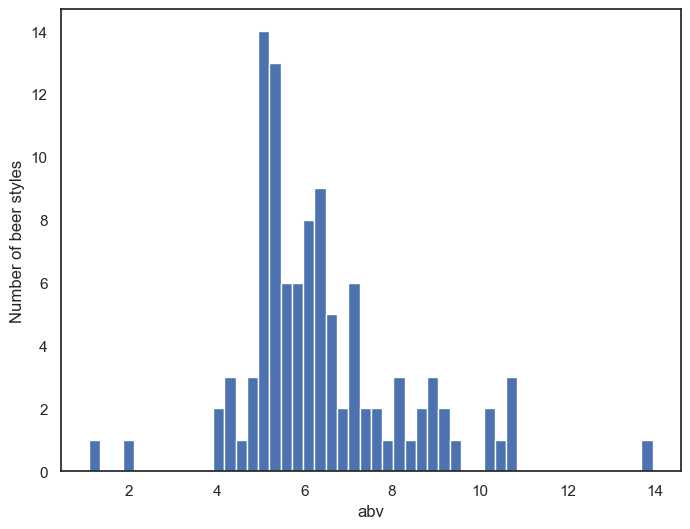

In [12]:
plt.hist(style_abv, bins=50)
plt.xlabel('abv')
plt.ylabel('Number of beer styles')

It appears that the abv could potentially be exploited to discrimate styles between one another. 

Back with our *beer_merged* dataframe, We group by styles and average the different ratings over each different style as was done with 'abv'.

In [13]:
style_features = beers_merged.groupby('style').mean()
style_features

,appearance,aroma,palate,taste,overall,rating
style,,,,,,
Altbier,3.804970,3.639206,3.712032,3.734094,3.767099,3.688162
American Adjunct Lager,2.834799,2.557520,2.768130,2.722332,2.881181,2.622378
American Amber / Red Ale,3.847400,3.695537,3.722954,3.749445,3.775169,3.740720
American Amber / Red Lager,3.535507,3.269277,3.384669,3.396695,3.482003,3.340731
American Barleywine,4.040312,4.021135,4.006163,4.046653,3.974425,4.028173
...,...,...,...,...,...,...
Vienna Lager,3.677319,3.458537,3.563928,3.592847,3.663178,3.556377
Weizenbock,4.007100,4.021994,3.993293,4.058172,4.013157,4.044141
Wheatwine,3.938947,3.967110,3.943702,3.975081,3.898842,3.952787


The distribution of those attributes among the population of beer styles is plotted below.

Text(0, 0.6, 'Number of beer styles')

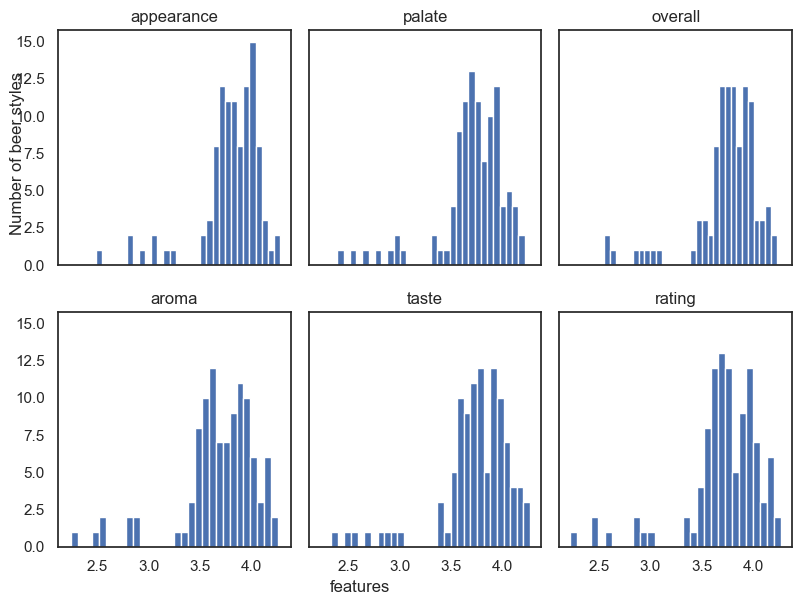

In [14]:
fig, ax = plt.subplots(2,3, sharey = True, sharex = True)

for i in range(6):
    sbplt = ax[i%2, math.floor(i/2)]
    sbplt.hist(style_features.iloc[:,i], bins=30)
    sbplt.set_title(style_features.columns[i])
    
fig.tight_layout()

fig.text(0.4,0, "features")
fig.text(0,0.6, "Number of beer styles", rotation = 90)

There is one additional check that one could perform to see if our enterprise has any chance of succeeding. We can compare the distributions of those 6 attributes for beers belonging to two very different beer styles and see if indeed they differ. If the distribution for two very different beer styles are superimposed, discriminating them solely based on those attributes might be impossible.

Two different beer styles could for example be Pale Ale and Pale Lager. 

In [15]:
Pale_Lager_beer = beers_merged.loc[beers_merged['style'].apply(lambda x: False if x.find('Pale Lager') < 0 else True)].drop(['style'],axis=1)

In [16]:
Pale_Ale_beer = beers_merged.loc[beers_merged['style'].apply(lambda x: False if x.find('Pale Ale') < 0 else True)].drop(['style'],axis=1)

In [17]:
# does the data come from a normal distribution?
diagnostic.kstest_normal(Pale_Ale_beer['rating'].dropna().values.astype(float), dist = 'norm')

(0.08716424114413229, 0.0009999999999998899)

- the pvalue is lower than some threshold, e.g. 0.05, then we can reject the Null hypothesis that the sample comes from a normal distribution.

In [18]:
stats.ttest_ind(Pale_Ale_beer['palate'].dropna().values.astype(float), Pale_Lager_beer['palate'].dropna().values.astype(float))

Ttest_indResult(statistic=209.9705189963642, pvalue=0.0)

- p is smaller than 0.05 -> we reject the null hypothesis that the feature come from the same -> there is a significant difference

In [19]:
def normal(mean, std, sbplt, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = norm.pdf(x, mean, std)
    sbplt.plot(x, p, color, linewidth=2)

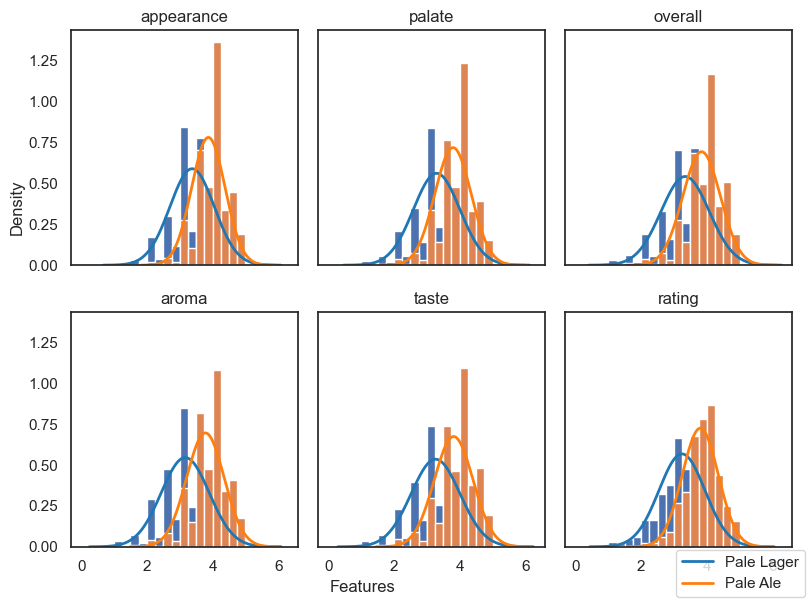

In [20]:
fig, ax = plt.subplots(2,3,figsize= (8,6), sharey = True, sharex = True)

for i,feature in enumerate(style_features.columns):
    sbplt = ax[i%2, math.floor(i/2)]
    sbplt.hist(Pale_Lager_beer[feature], bins=np.arange(0,5.25,0.25), density=True)
    normal(Pale_Lager_beer[feature].mean(), Pale_Lager_beer[feature].std(), sbplt, '#1f77b4')
    sbplt.hist(Pale_Ale_beer[feature], bins=np.arange(0,5.25,0.25), density=True)
    normal(Pale_Ale_beer[feature].mean(), Pale_Ale_beer[feature].std(), sbplt, '#ff7f0e')
    sbplt.set_title(feature)
    
fig.tight_layout()

fig.text(0.4,0, "Features")
fig.text(0,0.6, "Density", rotation = 90)
fig.legend(['Pale Lager','Pale Ale'], loc='lower right')

We see that the distributions are indeed shifted. 

Closing the parenthesis, we can now add back the 'abv' feature that was computed using the *beer* dataframe. 

In [21]:
style_features['abv'] = style_abv
style_features

,appearance,aroma,palate,taste,overall,rating,abv
style,,,,,,,
Altbier,3.804970,3.639206,3.712032,3.734094,3.767099,3.688162,5.681312
American Adjunct Lager,2.834799,2.557520,2.768130,2.722332,2.881181,2.622378,4.942573
American Amber / Red Ale,3.847400,3.695537,3.722954,3.749445,3.775169,3.740720,6.047384
American Amber / Red Lager,3.535507,3.269277,3.384669,3.396695,3.482003,3.340731,5.450313
American Barleywine,4.040312,4.021135,4.006163,4.046653,3.974425,4.028173,10.787476
...,...,...,...,...,...,...,...
Vienna Lager,3.677319,3.458537,3.563928,3.592847,3.663178,3.556377,5.143708
Weizenbock,4.007100,4.021994,3.993293,4.058172,4.013157,4.044141,7.546863
Wheatwine,3.938947,3.967110,3.943702,3.975081,3.898842,3.952787,10.162399


We also keep track of the names of the different beer styles that will be our labels.

In [22]:
style_labels = style_features.index

We convert our features to a numpy array.

In [23]:
X = style_features.to_numpy()

We standardize them as it is done before PCA to cancel the effect of different variances between features in our initial data.

In [24]:
#X = (X - X.mean(axis=0))/X.std(axis=0)
X = StandardScaler().fit_transform(style_features.to_numpy())

Now now we have all of our features in place, we can perform PCA.

In [25]:
X_reduced_pca = PCA(n_components=2).fit(X).transform(X)

# Plot the data reduced in 2d space with PCA
fig = px.scatter(x=X_reduced_pca[:,0], y=X_reduced_pca[:,1], color=style_labels)
fig.update_layout(
    title='PCA - Beer styles',
    width=1000,
    height=600,
)
fig.show()

Visually, groups are hardly distinguishable.

Considering projections on other PCA components, the results remain quite disappointing. 

In [26]:
pca = PCA()
components = pca.fit_transform(X)
labels_var = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels_var,
    dimensions=range(4),
    color=style_labels,
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title='PCA - Beer styles',
    width=1000,
    height=600,
)
fig.show()

Trying out with T-SNE does not yield more meaningful insight.

In [27]:
X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(X)

# Plot the data reduced in 2d space with t-SNE
fig = px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=style_labels)
fig.update_layout(
    title='T-SNE - Beer styles',
    width=1000,
    height=600,
)
fig.show()

Note that PCA is an unsupervised linear technique for dimensionality reduction. Some non-linear techniques such as UMAP can further be explored in an attempt to gain further insight. 

In [28]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X)

fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=style_labels)
fig.update_layout(
    title='UMAP - Beer styles',
    width=1000,
    height=600,
)
fig.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Note that there are some groups that start to emerge a bit more distinctly but those results remain hardly exploitable. Some styles that are projected near to one another would not instinctively be considered similar from common-sense knowledge.

Since it is hard to determine them visually, let us now use clustering to try to retrieve some clusters and reason about them.
Note here that an arbitrary number of beer style groups have been selected (16).

In [29]:
# Cluster the data in 16 groups
Klabels = KMeans(n_clusters= 16, random_state=0).fit_predict(X)

This clustering can easily be vizualised thanks to PCA. 

In [30]:
fig = px.scatter(x=X_reduced_pca[:,0], y=X_reduced_pca[:,1], color=Klabels)
fig.update_layout(
    title='K-Means - Beer styles (PCA projections)',
    width=1000,
    height=600,
)
fig.show()

Let us dive a bit more into the different clusters and examine which styles they are made of.

In [31]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = style_features.index.values
cluster_map['cluster'] = Klabels

In [32]:
cluster_map

,data_index,cluster
0,Altbier,14
1,American Adjunct Lager,4
2,American Amber / Red Ale,14
3,American Amber / Red Lager,10
4,American Barleywine,8
...,...,...
99,Vienna Lager,0
100,Weizenbock,1
101,Wheatwine,8
102,Winter Warmer,6


In [33]:
for i in range(max(Klabels)+1):
     display(cluster_map[cluster_map.cluster == i])

,data_index,cluster
6,American Blonde Ale,0
8,American Dark Wheat Ale,0
16,American Pale Wheat Ale,0
31,Bock,0
35,Cream Ale,0
36,Czech Pilsener,0
38,Dortmunder / Export Lager,0
43,English Bitter,0
45,English Dark Mild Ale,0
46,English India Pale Ale (IPA),0


,data_index,cluster
5,American Black Ale,1
12,American IPA,1
17,American Porter,1
18,American Stout,1
23,Belgian IPA,1
29,Bière de Garde,1
57,Flanders Oud Bruin,1
59,Foreign / Export Stout,1
79,Milk / Sweet Stout,1
83,Oatmeal Stout,1


,data_index,cluster
53,Euro Pale Lager,2
64,Happoshu,2
69,Japanese Rice Lager,2


,data_index,cluster
9,American Double / Imperial IPA,3
11,American Double / Imperial Stout,3
86,Quadrupel (Quad),3
89,Russian Imperial Stout,3


,data_index,cluster
1,American Adjunct Lager,4
13,American Malt Liquor,4


,data_index,cluster
10,American Double / Imperial Pilsner,5
21,Baltic Porter,5
26,Belgian Strong Pale Ale,5
28,Bière de Champagne / Bière Brut,5
37,Doppelbock,5
39,Dubbel,5
94,Scotch Ale / Wee Heavy,5
98,Tripel,5


,data_index,cluster
22,Belgian Dark Ale,6
32,Braggot,6
51,English Strong Ale,6
78,Maibock / Helles Bock,6
85,Pumpkin Ale,6
91,Sahti,6
102,Winter Warmer,6


,data_index,cluster
41,Eisbock,7


,data_index,cluster
4,American Barleywine,8
19,American Strong Ale,8
25,Belgian Strong Dark Ale,8
42,English Barleywine,8
84,Old Ale,8
101,Wheatwine,8


,data_index,cluster
7,American Brown Ale,9
14,American Pale Ale (APA),9
27,Berliner Weissbier,9
49,English Porter,9
50,English Stout,9
62,Gose,9
87,Rauchbier,9
90,Rye Beer,9
97,Smoked Beer,9


,data_index,cluster
3,American Amber / Red Lager,10
15,American Pale Lager,10
30,Black & Tan,10
34,Chile Beer,10
52,Euro Dark Lager,10
60,Fruit / Vegetable Beer,10
72,Kvass,10


,data_index,cluster
54,Euro Strong Lager,11


,data_index,cluster
77,Low Alcohol Beer,12


,data_index,cluster
20,American Wild Ale,13
58,Flanders Red Ale,13
63,Gueuze,13
74,Lambic - Fruit,13
75,Lambic - Unblended,13


,data_index,cluster
0,Altbier,14
2,American Amber / Red Ale,14
24,Belgian Pale Ale,14
33,California Common / Steam Beer,14
40,Dunkelweizen,14
44,English Brown Ale,14
55,Extra Special / Strong Bitter (ESB),14
56,Faro,14
65,Hefeweizen,14
67,Irish Dry Stout,14


,data_index,cluster
76,Light Lager,15


This is not conclusive as the clusters do not really make sense sometimes. 

For some beer styles the results are a bit more encouraging. Among the 8 different stouts, 4 are grouped together in cluster 1 and 2 in cluster 3 for example. Another example is the two Barleywines of the dataset (the American and English Barleywines) that also end up together in cluster 8. But some beer styles such as ales and lagers should be separated and pertain to different categories but fall within the same cluster (e.g 0).  Some beer styles are being grouped together but should not be according to common sense. 

A possible explanation to those poor results is the following: users that have rated those beers might be very much so the . The analysis would be much more robust considering group of users that share similar understanding and rates in a similar way. To examine how Beer styles in a coherent manner. The problem of identifying group of users is either way part of our datastory and has been done in an other section. 

Let us try this and see if the results improve. 

In [35]:
users = pd.read_pickle(DATA_FOLDER + 'users.pkl')
breweries = pd.read_pickle(DATA_FOLDER + 'breweries.pkl')

In [ ]:
merged_data = users[['user_id', 'nbr_ratings', 'nbr_reviews', 'location']]
merged_data = merged_data.merge(ratings[['user_id', 'beer_id']], on='user_id')
merged_data = merged_data.merge(beers[['beer_id','style', 'brewery_id']], on='beer_id')
merged_data = merged_data.merge(breweries[['id', 'location']], left_on='brewery_id', right_on='id')

merged_data.drop(['brewery_id', 'id'], axis = 1, inplace=True)
merged_data.rename(columns={'location_x': 'user_location', 'location_y': 'beer_location'}, inplace=True)
merged_data

In [ ]:
ratings_per_beer = ratings.groupby('beer_id')['beer_id'].agg(['count']).reset_index().rename(columns={'count':'nbr_ratings'})
#ratings_per_beer = ratings_per_beer.merge(merged_data[['beer_id', 'beer_location']], on='beer_id', how='inner')
#ratings_per_beer.drop_duplicates(inplace=True, ignore_index=True)
#ratings_per_country = ratings_per_beer.groupby('beer_location')['nbr_ratings'].agg(['sum']).reset_index()
#ratings_per_beer = ratings_per_beer.merge(ratings_per_country[['beer_location', 'sum']], on='beer_location')
#ratings_per_beer['sum'] = ratings_per_beer['nbr_ratings']/ratings_per_beer['sum']
#ratings_per_beer.rename(columns={'sum':'scarcity'})
ratings_per_beer

In [ ]:
ratings_per_beer['scarce_beer'] =  ratings_per_beer['nbr_ratings'].apply(lambda x: True if x<10 else False)

In [ ]:
merged_data = merged_data.merge(ratings_per_beer[['beer_id', 'scarce_beer']], on='beer_id', how='inner')

In [ ]:
users['experienced_user'] = users['nbr_ratings'].apply(lambda x: True if x>39 else False)
users['novice_user'] = users['nbr_ratings'].apply(lambda x: True if x<3 else False) 

In [ ]:
users['explorator']=False

for group_user_id, group in tqdm(merged_data.groupby('user_id')):
    user = " "
    user = user.join(group.user_id.unique())
    #print(group.beer_id)
    for beer in group.beer_id:
        if ratings_per_beer.loc[ratings_per_beer.beer_id == beer,'scarce_beer'].bool():
            users.loc[users.user_id == user, 'explorator'] = True
            break

In [ ]:
ratings_users = pd.merge(ratings, users, left_on='user_id', right_on='user_id')
ratings_users

In [ ]:
beers_merged_users = pd.merge(ratings_users, beers, left_on='beer_id', right_on='beer_id')
beers_merged_users

In [ ]:
beers_merged1 = beers_merged_users.loc[beers_merged.experienced_user][['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'style']]
beers_merged1

In [ ]:
beers_merged2 = beers_merged_users.loc[beers_merged.novice_user][['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'style']]
beers_merged2

In [ ]:
beers_merged3 = beers_merged_users.loc[beers_merged.explorator][['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'style']]
beers_merged3

In [ ]:
style_features = beers_merged3.groupby('style').mean()
style_features

In [ ]:
style_abv = beers.groupby('style').mean()['abv']

In [ ]:
style_features['abv'] = style_abv
style_features

In [ ]:
style_labels = style_features.index

In [ ]:
X = style_features.to_numpy()

In [ ]:
X = StandardScaler().fit_transform(style_features.to_numpy())

In [ ]:
X_reduced_pca = PCA(n_components=2).fit(X).transform(X)

# Plot the data reduced in 2d space with PCA
fig = px.scatter(x=X_reduced_pca[:,0], y=X_reduced_pca[:,1], color=style_labels)
fig.update_layout(
    title='PCA - Beer styles',
    width=1000,
    height=600,
)
fig.show()

This is not very conclusive as well.

A possible explanation could be BLABLABLA

Note that in this process of regrouping styles together we won't start from scratch as our previous results has been quite unsatisfactory. Our earlier analysis has suggested that directly trying to group beer styles in an unsupervised manner (PCA, t-SNE, UMAP, K-Means) based on the features at our disposal (abv and various ratings) was not delivering satisfying results when confronted with accepted knowledge about beer styles. 

As a workaround, we rely on domain experts that have already come up with some beer style categories with similar beer styles (similar in terms of a number of criteria listed by the experts) falling withing the same category. Those groups or "supra-styles" can be found on https://www.craftbeer.com/beer/beer-styles-guide.


The subsequent analysis aims now at validating those groups given our dataset. 

15 different "supra-styles" have been identified by the experts (see link above), each one of them comprising several similar beer styles. 

Diving in the code details:
We first define a list of lists, each of those lists being made up of strings of the names of different styles pertaining to the "supra-style".

In [ ]:
types_features = []
types_features.append(["amber ale", "american pale ale", "english pale ale", "blonde ale", "bitter"])     #Pale Ales
types_features.append(["amber lager", "dunkel", "marzen", "oktoberfest", "schwarzbier", "vienna lager", "dark lager", "red lager"])    #Dark Lagers
types_features.append(["brown ale", "mild"])     #Brown Ales
types_features.append(["ipa", "indian pale ale"])     #India Pale Ales
types_features.append(["wheat wine ale", "wheat", "witbier", "weisse", "weissbier", "dunkelweizen", "hefeweizen", "kristalweizen"])     #Wheat Beers
types_features.append(["barley wine", "barleywine",  "imperial red ale", "barley wine ale", "old ale", "strong ale", "strong pale ale"])     #Strong Ales
types_features.append(["belgian blonde ale", "dubbel", "belgian strong dark ale", "belgian dark ale", "golden strong ale", "belgian pale ale", "quadrupel", "saison", "tripel"])     #Belgian Styles
types_features.append(["cream ale", "biere de garde", "bière de garde", "common", "altbier", "kolsch", "kölsch", "red beer", "red ale"])     #Hybrid Beers
types_features.append(["porter"])     #Porters
types_features.append(["stout"])     #Stouts
types_features.append(["bock", "doppelbock", "maibock", "weizenbock"])     #Bocks
types_features.append(["heavy", "scottish ale"])     #Scottish-Style Ales
types_features.append(["brett", "sour", "flanders", "lambic", "faro", "gueuze", "gose", "wild"])     #Wild/Sour Beers
types_features.append(["pale lager", "american Lager", "american adjunct lager", "pilsener", "pilsner", "export", "helles"])     #Pilseners and Pale Lagers
types_features.append(["black ale", "barrel-aged", "chocolate", "coffee", "fruit", "field", "craft", "herb", "spice", "honey", "pumpkin", "rye", "roggenbier", "session", "smoke", "rauchbier", "specialty", "sahti"])     #Specialty Beers

Every element of one list becomes a key in a dictionnary and is assigned the same value.

In [ ]:
types = {}
for i,type_features in enumerate(types_features):
    for key in type_features:
        types[key] = i

We create a new column in our *beers_merged* dataframe which encapsulates which "supra-styles" each beer style belongs to.

Note: the 16th "supra-style" corresponds to beer styles that do not fit in the 15 "supra-styles" picked by the experts.

In [ ]:
beers_merged["style_merged"] = 15.
for type, label in types.items():
    beers_merged["bool"] = beers_merged["style"].apply(lambda x: type in x.lower())
    beers_merged.loc[beers_merged["bool"], "style_merged"] = label
    del beers_merged['bool']
beers_merged

,appearance,aroma,palate,taste,overall,rating,style,style_merged
0,3.25,2.75,3.25,2.75,3.0,2.88,Euro Pale Lager,13.0
1,3.00,3.50,3.50,4.00,3.5,3.67,English Pale Ale,0.0
2,4.00,3.50,3.50,4.00,3.5,3.73,English Pale Ale,0.0
3,4.00,3.50,4.00,4.00,4.5,3.98,English Pale Ale,0.0
4,4.00,4.00,4.00,4.00,4.0,4.00,English Pale Ale,0.0
...,...,...,...,...,...,...,...,...
8393027,3.50,3.50,3.50,4.00,4.0,3.80,Kölsch,7.0
8393028,3.00,3.00,3.00,2.50,3.0,2.80,Kölsch,7.0
8393029,3.00,1.50,1.00,1.50,1.5,1.54,Kölsch,7.0
8393030,NaN,NaN,NaN,NaN,NaN,3.50,English Brown Ale,2.0


For example, the **Dark Lagers** supra-styles (style_merged = 1.) that have been defined by the experts as regrouping:

- American Amber Lager
- German-Style Dunkel
- German-Style Marzen / Oktoberfest
- German-Style Schwarzbier
- Vienna-Style Lager

contains the following styles from our dataset:

In [ ]:
beers_merged.loc[beers_merged.style_merged == 1.]['style'].unique()

array(['Schwarzbier', 'Vienna Lager', 'Märzen / Oktoberfest',
       'Euro Dark Lager', 'Munich Dunkel Lager',
       'American Amber / Red Lager'], dtype=object)

The non-defined beer styles (that we have not managed to classify in one of the "supra-styles" defined by the experts) are shown below: 

In [ ]:
list(beers_merged.loc[beers_merged.style_merged == 15.]['style'].unique())

['Winter Warmer',
 'Black & Tan',
 'Low Alcohol Beer',
 'Chile Beer',
 'Euro Strong Lager',
 'Light Lager',
 'Kellerbier / Zwickelbier',
 'Braggot',
 'American Malt Liquor',
 'Kvass',
 'Bière de Champagne / Bière Brut',
 'Japanese Rice Lager',
 'Happoshu']

In [ ]:
beers_merged.loc[beers_merged.style_merged == 15.0]['style'].nunique()

13

"Only" 13 styles have not been merged which is quite satisfactory given our 104 styles initially. Some research indicated that most of those are in fact quite singular which explains why there are not easily regrouped.

Let us try now to observe how those newly labelled beer styles (16 "supra-styles") fit with our data when projected using the dimensionality reduction techniques cited above. That would be interesting to see if beer styles that have now been identified as pertaining to one supra-style end up closer compared to styles from other supra-styles. This would come as some sort of validation.

Note that the steps followed are sensibly the same as the previous ones so they will not be commented.

In [ ]:
style_features = beers_merged.groupby('style').mean()

In [ ]:
supra_styles = ["Pale Ales", "Dark Lagers", "Brown Ales", "India Pale Ales", "Wheat Beers", "Strong Ales", "Belgian Styles", "Hybrid Beers", "Porters", "Stouts", "Bocks", "Scottish-Style Ales", "Wild/Sour Beers", "Pilseners and Pale Lagers", "Specialty Beers", "Undefined"]
style_features.style_merged = style_features.style_merged.apply(lambda x: supra_styles[int(x)])
style_features

,appearance,aroma,palate,taste,overall,rating,style_merged
style,,,,,,,
Altbier,3.804970,3.639206,3.712032,3.734094,3.767099,3.688162,Hybrid Beers
American Adjunct Lager,2.834799,2.557520,2.768130,2.722332,2.881181,2.622378,Pilseners and Pale Lagers
American Amber / Red Ale,3.847400,3.695537,3.722954,3.749445,3.775169,3.740720,Hybrid Beers
American Amber / Red Lager,3.535507,3.269277,3.384669,3.396695,3.482003,3.340731,Dark Lagers
American Barleywine,4.040312,4.021135,4.006163,4.046653,3.974425,4.028173,Strong Ales
...,...,...,...,...,...,...,...
Vienna Lager,3.677319,3.458537,3.563928,3.592847,3.663178,3.556377,Dark Lagers
Weizenbock,4.007100,4.021994,3.993293,4.058172,4.013157,4.044141,Bocks
Wheatwine,3.938947,3.967110,3.943702,3.975081,3.898842,3.952787,Wheat Beers


In [ ]:
style_labels = style_features.index
style_labels_merged = style_features.pop("style_merged")

In [ ]:
X = StandardScaler().fit_transform(style_features.to_numpy())

In [ ]:
X_reduced_pca = PCA(n_components=2).fit(X).transform(X)

# Plot the data reduced in 2d space with PCA
fig = px.scatter(x=X_reduced_pca[:,0], y=X_reduced_pca[:,1], color=style_labels_merged, color_discrete_sequence=px.colors.qualitative.Light24)
fig.update_layout(
    title='PCA - Beer styles',
    width=1000,
    height=600,
)
fig.show()

The results are definitely not optimal but some beer styles within supra-styles do seem to fall closer to each others compared to randomly taken beer styles. Take the stouts (yellow) for example that are "quite" concentrated, or the Strong Ales. 

We can repeat the analysis projecting the beer styles on other components of PCA.

In [ ]:
pca = PCA()
components = pca.fit_transform(X)
labels_var = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels_var,
    dimensions=range(4),
    color=style_labels_merged,
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title='PCA - Beer styles',
    width=1000,
    height=600,
)
fig.show()

Or with t-SNE:

In [ ]:
X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(X)

# Plot the data reduced in 2d space with t-SNE
fig = px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=style_labels_merged, color_discrete_sequence=px.colors.qualitative.Light24)
fig.update_layout(
    title='T-SNE - Beer styles',
    width=1000,
    height=600,
)
fig.show()

With UMAP, it gives:

In [ ]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X)

fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=style_labels_merged, color_discrete_sequence=px.colors.qualitative.Light24)
fig.update_layout(
    title='UMAP - Beer styles',
    width=1000,
    height=600,
)
fig.show()

Once again, we see that beer styles belonging to the same supra-style fall close to each other. 